## Import library

In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Load Data

In [4]:
# Load the data from the files
training_data = np.load('training/processed_data.npy')
valid_periods = np.load('training/valid_periods.npy')
categories = np.load('training/categories.npy')

training_data.shape, valid_periods.shape, categories.shape

((48000, 2776), (48000, 2), (48000,))

In [5]:
# Convert training_data and categories to DataFrame
data_df = pd.DataFrame(training_data, columns=[f'Timestep_{i+1}' for i in range(training_data.shape[1])])
categories_df = pd.DataFrame(categories, columns=['Category'])

# Concatenate DataFrames along the columns
df = pd.concat([data_df, categories_df], axis=1)

# Display the resulting DataFrame
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2777 entries, Timestep_1 to Category
dtypes: float64(2776), object(1)
memory usage: 1017.0+ MB


,Timestep_1,Timestep_2,Timestep_3,Timestep_4,Timestep_5,Timestep_6,Timestep_7,Timestep_8,Timestep_9,Timestep_10,...,Timestep_2767,Timestep_2768,Timestep_2769,Timestep_2770,Timestep_2771,Timestep_2772,Timestep_2773,Timestep_2774,Timestep_2775,Timestep_2776
count,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,...,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000
mean,0.294617,0.296570,0.311277,0.312676,0.315905,0.327528,0.324596,0.323519,0.326198,0.324225,...,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000006,0.000006,0.000006,0.000005
std,0.313868,0.309717,0.316246,0.316806,0.308752,0.312038,0.312138,0.310601,0.308453,0.306235,...,0.001105,0.001194,0.001158,0.001136,0.001151,0.001191,0.001223,0.001242,0.001232,0.001197
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.017053,0.026143,0.036552,0.041840,0.048021,0.054732,0.053503,0.053497,0.059964,0.062067,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.164482,0.166667,0.179424,0.177778,0.189224,0.204628,0.198634,0.199197,0.202721,0.200518,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.530799,0.531936,0.558958,0.557046,0.563917,0.585731,0.580660,0.577783,0.579325,0.570832,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.242176,0.261673,0.253678,0.248855,0.252103,0.260920,0.267974,0.272139,0.269904,0.262239


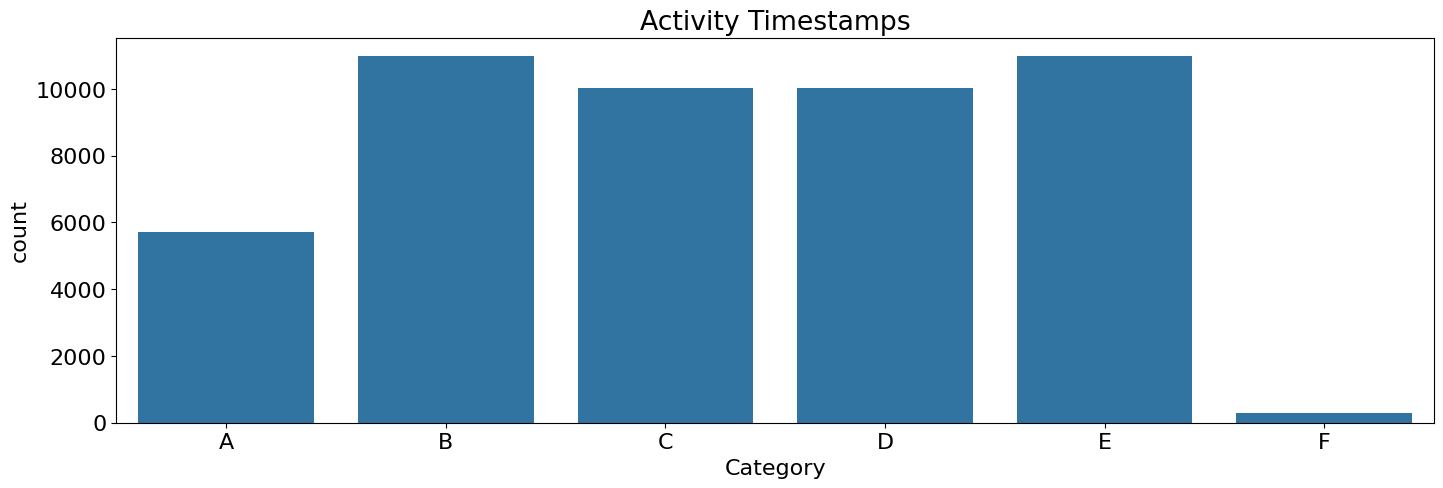

In [6]:
# Inspect activities timestamps
plt.figure(figsize=(17,5))
sns.countplot(x = 'Category', data = df, order = sorted(df['Category'].unique()))
plt.title('Activity Timestamps')
plt.show()

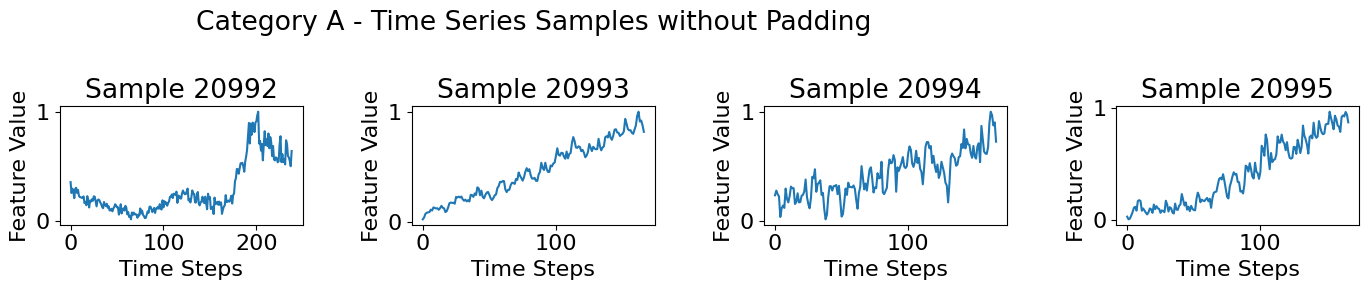

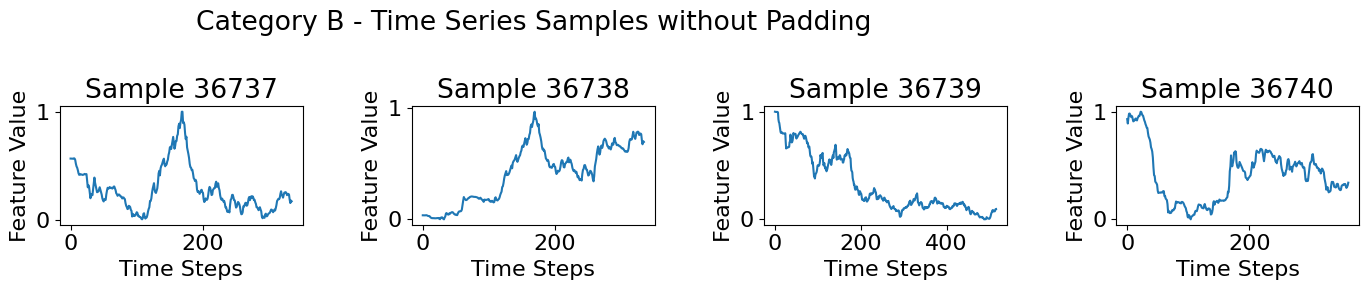

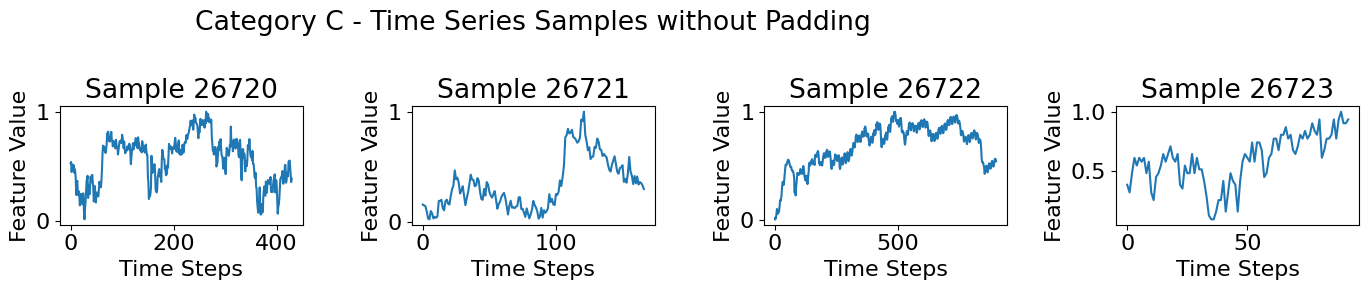

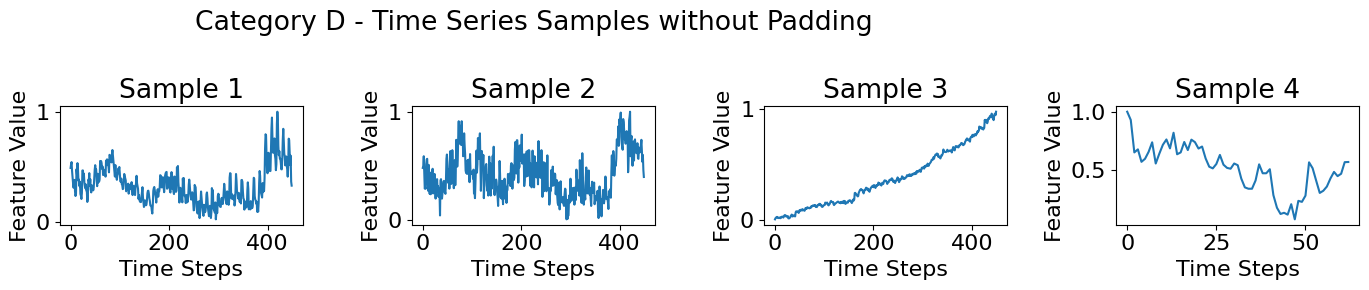

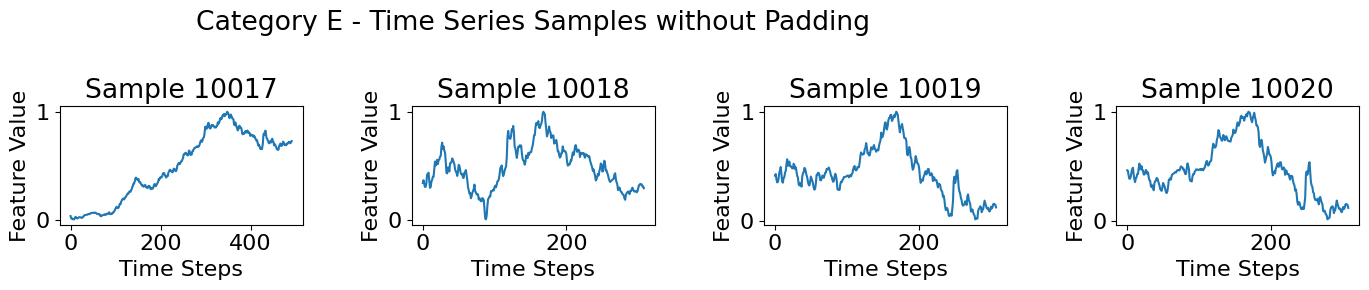

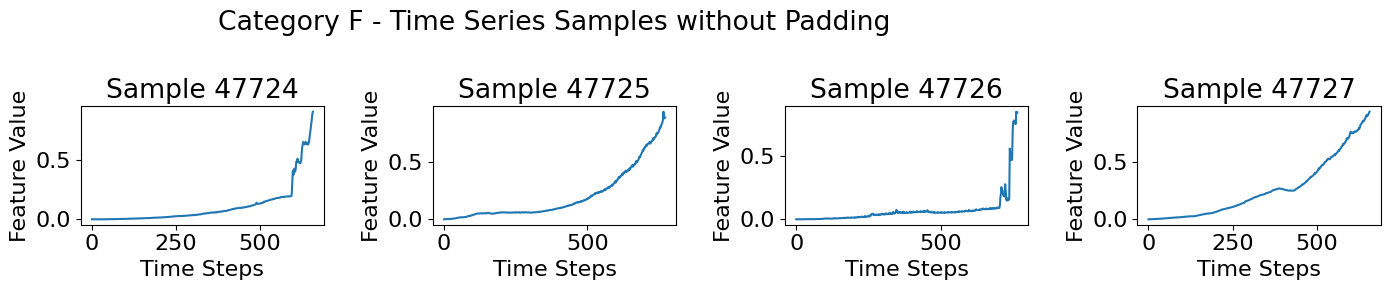

In [7]:
# Plot some samples without padding
for category in "ABCDEF":
    to_be_inspected = 4

    plt.figure(figsize=(17, 3))  # Adjust the figure size as needed
    plt.suptitle(f'Category {category} - Time Series Samples without Padding')

    for idx in range(len(training_data)):
        if to_be_inspected == 0:
            break

        if categories[idx] != category:
            continue

        # Find the non-zero indices in the time series
        non_zero_indices = np.nonzero(training_data[idx])[0]

        # Trim the time series to remove padding
        trimmed_series = training_data[idx, non_zero_indices]

        plt.subplot(1, 5, 6 - to_be_inspected)  # 1 row, 5 columns, and the current plot position
        plt.plot(trimmed_series)
        plt.title(f'Sample {idx + 1}')
        plt.xlabel('Time Steps')
        plt.ylabel('Feature Value')

        to_be_inspected -= 1

    plt.tight_layout()  # Adjust layout for better appearance
    plt.show()


## Data Preprocessing

### Handling Missing Value

In [8]:
# Check for missing values
missing_values_before = np.isnan(training_data)
if np.any(missing_values_before):
    print("Number of missing values before replacement:", np.sum(missing_values_before))
    # Visualize the data before replacement (optional)
    plt.figure(figsize=(15, 6))
    plt.imshow(missing_values_before, cmap='viridis', aspect='auto')
    plt.title('Missing Values Before Replacement')
    plt.xlabel('Time Steps')
    plt.ylabel('Samples')
    plt.show()

    # Replace missing values with the mean of the column
    training_data = np.nan_to_num(training_data, nan=np.nanmean(training_data))

    # Check for missing values after replacement
    missing_values_after = np.isnan(training_data)
    print("Number of missing values after replacement:", np.sum(missing_values_after))
    # Visualize the data after replacement (optional)
    plt.figure(figsize=(15, 6))
    plt.imshow(missing_values_after, cmap='viridis', aspect='auto')
    plt.title('Missing Values After Replacement')
    plt.xlabel('Time Steps')
    plt.ylabel('Samples')
    plt.show()
else:
    print("No missing values in the training data.")


No missing values in the training data.


In [13]:
from scipy import stats

# Select only numeric columns from the dataset
numeric_columns = df.select_dtypes(include=np.number)

# Sample a subset of your numeric data (adjust the sample size as needed)
sample_size = 40000
sampled_data = numeric_columns.sample(sample_size, random_state=42)

# Calculate Z-scores for the sampled data
z_scores = np.abs(stats.zscore(sampled_data))

# Identify outliers based on Z-scores
outliers = (z_scores > 3).any(axis=1)

# Display the outliers in the sampled data
outlier_samples = sampled_data[outliers]
print("Outlier samples:")
print(outlier_samples)


Outlier samples:
       Timestep_1  Timestep_2  Timestep_3  Timestep_4  Timestep_5  Timestep_6  \
3377     0.416930    0.493055    0.476274    0.466105    0.441091    0.367637   
4831     0.004082    0.030201    0.051538    0.064781    0.044375    0.044050   
24471    0.106397    0.112044    0.107337    0.102086    0.097548    0.084792   
41583    0.000000    0.006552    0.005531    0.004099    0.012425    0.012271   
5662     0.093304    0.066794    0.066635    0.047451    0.016134    0.033945   
...           ...         ...         ...         ...         ...         ...   
15450    0.478984    0.427320    0.435201    0.479860    0.500876    0.487741   
32888    0.012780    0.011136    0.034961    0.022273    0.023460    0.016613   
328      0.049953    0.059378    0.067861    0.073516    0.079171    0.071631   
4710     0.017284    0.000000    0.012346    0.014815    0.039506    0.044444   
27382    0.157364    0.148837    0.151163    0.153488    0.150388    0.150388   

       Tim

### Scaling or Normalize

In [111]:
features = df.drop('Category', axis=1)
target = df['Category']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)

# Display the shapes of the resulting sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (38400, 2776) (38400,)
Testing set shape: (9600, 2776) (9600,)


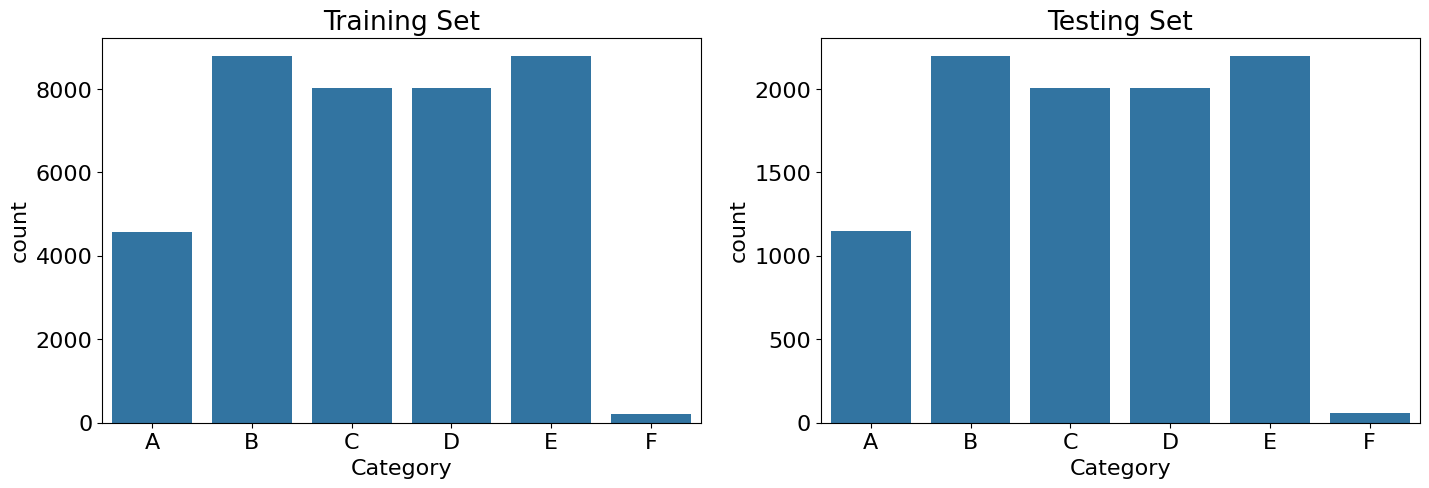

In [112]:
import seaborn as sns
# Plot for training set
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, and the first plot
sns.countplot(x=y_train, order=sorted(y_train.unique()))
plt.title('Training Set')

# Plot for testing set
plt.subplot(1, 2, 2)  # 1 row, 2 columns, and the second plot
sns.countplot(x=y_test, order=sorted(y_test.unique()))
plt.title('Testing Set')

plt.show()

In [113]:
# Map categories to integers
category_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}

y_train = y_train.map(category_mapping)
y_test = y_test.map(category_mapping)

In [114]:
from sklearn.preprocessing import RobustScaler

# Initialize the RobustScaler (better because we have many outliers)
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Extracting Relevant Features

In [115]:
from tensorflow.keras.utils import to_categorical

forecasting_period_phase1 = 9
forecasting_period_phase2 = 18

y_train = to_categorical(y_train, num_classes=forecasting_period_phase1)
y_test = to_categorical(y_test, num_classes=forecasting_period_phase1)


## Model

In [116]:
input_shape = None
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

forecasting_period_phase1 = 9
forecasting_period_phase2 = 18

input_shape, classes, X_train.shape

(None, 9, (38400, 2776))

In [117]:
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl

def build_forecasting_model(input_shape, forecasting_period):
    # Input layer for categorical features
    input_layer = tfkl.Input(shape=(input_shape[0],), name='Input')  # Assuming input_shape is (num_features,)

    # Dense layers for feature extraction
    dense1 = tfkl.Dense(128, activation='relu')(input_layer)
    dense2 = tfkl.Dense(128, activation='relu')(dense1)
    dropout = tfkl.Dropout(0.5, seed=42)(dense2)

    # Dense layer for classification
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    
    # Forecasting layer
    forecasting_output = tfkl.Dense(forecasting_period, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=forecasting_output, name='forecasting_model')

    # Compile the model
    #model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    model.compile(loss=tfk.losses.MeanAbsoluteError(), optimizer=tfk.optimizers.Adam(), metrics=['mse'])

    # Return the model
    return model

Model: "forecasting_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2776)]            0         
                                                                 
 dense_16 (Dense)            (None, 128)               355456    
                                                                 
 dense_17 (Dense)            (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               16512     
                                                                 
 dense_19 (Dense)            (None, 9)                 1161      
                                                                 
Total params: 389641 (1.49 MB)
Trainable params: 

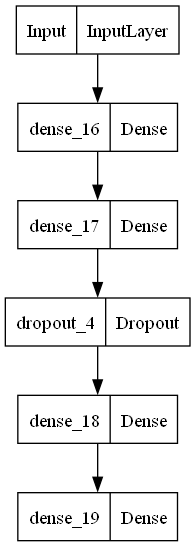

In [119]:
input_shape = (2776,)  # Adjust based on your actual input shape


output_steps = 9
# Build the forecasting model
model = build_forecasting_model(input_shape, output_steps)


# Display the model summary
model.summary()

# Plot the model architecture
tfk.utils.plot_model(model)

In [120]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
270/270 [==============================] - 4s 13ms/step - loss: 0.1566 - mse: 0.1423 - val_loss: 0.1486 - val_mse: 0.1465 - lr: 0.0010
Epoch 2/200
270/270 [==============================] - 3s 10ms/step - loss: 0.1482 - mse: 0.1440 - val_loss: 0.1420 - val_mse: 0.1378 - lr: 0.0010
Epoch 3/200
270/270 [==============================] - 3s 10ms/step - loss: 0.1416 - mse: 0.1370 - val_loss: 0.1420 - val_mse: 0.1399 - lr: 0.0010
Epoch 4/200
270/270 [==============================] - 3s 9ms/step - loss: 0.1390 - mse: 0.1346 - val_loss: 0.1374 - val_mse: 0.1324 - lr: 0.0010
Epoch 5/200
270/270 [==============================] - 3s 10ms/step - loss: 0.1369 - mse: 0.1327 - val_loss: 0.1385 - val_mse: 0.1350 - lr: 0.0010
Epoch 6/200
270/270 [==============================] - 3s 10ms/step - loss: 0.1360 - mse: 0.1325 - val_loss: 0.1355 - val_mse: 0.1326 - lr: 0.0010
Epoch 7/200
270/270 [==============================] - 3s 10ms/step - loss: 0.1355 - mse: 0.1322 - val_loss: 0.1376 - v

## Model ResNet + ConvlDs

In [121]:
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl

def build_resnet_forecasting_model(input_shape, forecasting_period):
    # Input layer for categorical features
    input_layer = tfkl.Input(shape=(input_shape[0],), name='Input')  # Assuming input_shape is (num_features,)

    # Initial Dense layer
    dense1 = tfkl.Dense(128, activation='relu')(input_layer)

    # First residual block
    x = tfkl.Dense(128, activation='relu')(dense1)
    x = tfkl.add([dense1, x])  # Residual connection
    x = tfkl.Dropout(0.5, seed=42)(x)

    # Second residual block
    x = tfkl.Dense(128, activation='relu')(x)
    x = tfkl.add([dense1, x])  # Residual connection
    x = tfkl.Dropout(0.5, seed=42)(x)

    # Dense layer for classification
    classifier = tfkl.Dense(128, activation='relu')(x)
    
    # Forecasting layer
    forecasting_output = tfkl.Dense(forecasting_period, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=forecasting_output, name='resnet_forecasting_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

Model: "resnet_forecasting_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 2776)]               0         []                            
                                                                                                  
 dense_20 (Dense)            (None, 128)                  355456    ['Input[0][0]']               
                                                                                                  
 dense_21 (Dense)            (None, 128)                  16512     ['dense_20[0][0]']            
                                                                                                  
 add (Add)                   (None, 128)                  0         ['dense_20[0][0]',            
                                                                     'dense

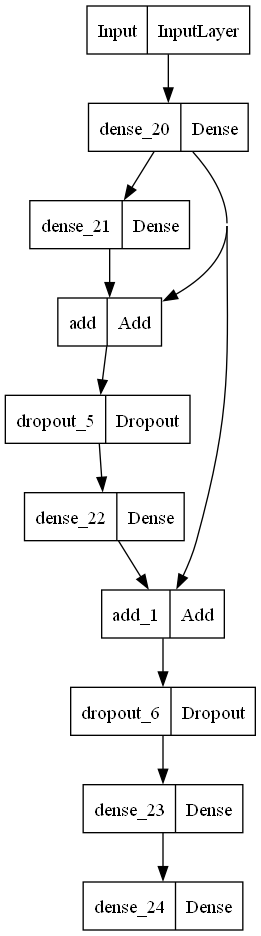

In [122]:
# Assuming input_shape is (2776,)
input_shape = (2776,)  

output_steps = 9
# Build the forecasting model
resnet_model = build_resnet_forecasting_model(input_shape, output_steps)

# Display the model summary
resnet_model.summary()

# Plot the model architecture
tfk.utils.plot_model(resnet_model)

In [124]:
# Train the model
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_mse', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_mse', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
270/270 [==============================] - 3s 11ms/step - loss: 0.1248 - mse: 0.1237 - val_loss: 0.1282 - val_mse: 0.1272 - lr: 6.2500e-05
Epoch 2/200
270/270 [==============================] - 3s 10ms/step - loss: 0.1245 - mse: 0.1234 - val_loss: 0.1283 - val_mse: 0.1272 - lr: 6.2500e-05
Epoch 3/200
270/270 [==============================] - 3s 10ms/step - loss: 0.1246 - mse: 0.1234 - val_loss: 0.1281 - val_mse: 0.1270 - lr: 6.2500e-05
Epoch 4/200
270/270 [==============================] - 3s 10ms/step - loss: 0.1246 - mse: 0.1234 - val_loss: 0.1280 - val_mse: 0.1271 - lr: 6.2500e-05
Epoch 5/200
270/270 [==============================] - 3s 10ms/step - loss: 0.1244 - mse: 0.1232 - val_loss: 0.1278 - val_mse: 0.1268 - lr: 6.2500e-05
Epoch 6/200
270/270 [==============================] - 3s 10ms/step - loss: 0.1241 - mse: 0.1230 - val_loss: 0.1277 - val_mse: 0.1267 - lr: 6.2500e-05
Epoch 7/200
270/270 [==============================] - 3s 10ms/step - loss: 0.1242 - mse: 0.12